In [1]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from definitions import ROOT_DIR
from unc.utils import load_info

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


In [3]:
level = 8
# all_paths = {
# #     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
#     f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn'),
#     f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn_lstm'),
# }
all_paths = {
#     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
    f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn'),
    f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn_lstm'),
}

plot_info = {
    f'uf{level}a_cnn': {'color': midnight_blue, 'label': 'Ground-truth'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0': {'color': sunflower, 'label': 'LSTM'},
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95': {'color': wisteria, 'label': 'LSTM + uncertainty'},
    f'uf{level}m_cnn_uncertainty_decay_1.0': {'color': green_sea, 'label': 'Normal'},
    f'uf{level}m_cnn_uncertainty_decay_0.85': {'color': pumpkin, 'label': 'Uncertainty'}
}

plot_order = [
#     f'uf{level}a_cnn',
    f'uf{level}m_cnn_uncertainty_decay_1.0',
    f'uf{level}m_cnn_lstm_uncertainty_decay_1.0',
    f'uf{level}m_cnn_uncertainty_decay_0.85',
    f'uf{level}m_cnn_lstm_uncertainty_decay_0.95'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc', 'total_steps']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [4]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
#         if args["total_steps"] < 4e6:
#             continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [5]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [6]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [7]:
arg_example = list(raw_data[f'uf{level}m_cnn'].values())[0][0][2]
steps_per_eval = arg_example['offline_eval_freq']

In [8]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [9]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [10]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [11]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [12]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf8m_cnn_uncertainty_decay_0.85': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=0.85, slip_prob=0.1, trunc=10, total_steps=3000000),
  22.028839999999995,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/de1674d63f4ce36682b31736211ccc97_Sun May 15 10:09:59 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/33df241585146880e67935dae096588f_Sun May 15 10:11:57 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/a635d162126a5e6787d17f94a2730141_Sun May 15 10:09:59 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/c49486bf95a4566618b49595562eef3f_Sun May 15 10:11:57 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/e84fcae545aa5b003f92defeecd293b8_Sun May 15 10:09:59 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8m_cnn/e4f2521bccc1c9e4388672789a22c4f8_Sun May 15 10:09:59 2022.npy'),
   PosixPath

In [13]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [14]:
all_mapped_data_slip

{'uf8m_cnn_uncertainty_decay_0.85': array([[ 4.1 ,  9.6 ,  9.7 , ..., 26.78, 26.18, 27.16],
        [10.82, 15.7 , 19.34, ..., 20.26, 15.16, 18.74],
        [16.84, 14.38, 18.74, ..., 21.14, 23.06, 23.5 ],
        ...,
        [ 5.2 , 16.46, 18.48, ..., 20.1 , 20.42, 20.88],
        [ 1.68, 18.04, 16.02, ..., 18.38, 19.52, 15.18],
        [ 2.28,  8.48, 14.74, ..., 23.44, 26.26, 24.26]]),
 'uf8m_cnn_uncertainty_decay_1.0': array([[21.18, 14.78, 15.84, ..., 15.58, 20.4 , 18.18],
        [ 4.56, 10.72,  8.54, ..., 18.64, 19.44, 19.96],
        [ 9.74, 14.78,  8.62, ..., 16.  , 18.12, 18.2 ],
        ...,
        [14.86, 16.02, 17.24, ..., 21.92, 18.68, 17.28],
        [ 8.94,  5.5 , 10.34, ..., 17.82, 23.34, 19.92],
        [ 2.18, -0.2 ,  7.88, ..., 20.38, 17.8 , 16.08]]),
 'uf8m_cnn_lstm_uncertainty_decay_0.95': array([[ 9.5 , 19.92, 18.08, ..., 21.52, 26.06, 26.08],
        [16.98, 12.72, 16.56, ..., 21.34, 23.02, 26.56],
        [ 6.2 ,  6.86,  6.94, ..., 25.06, 25.38, 23.42],
      

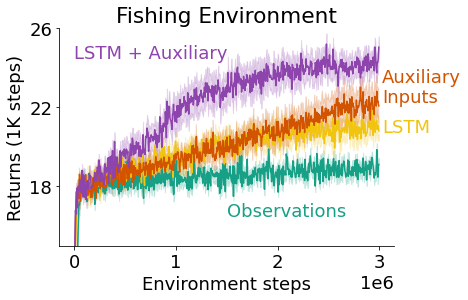

In [18]:
# with slip
fig, ax = plt.figure(), plt.axes()

fig_path = Path(ROOT_DIR, 'results', 'uf8_results.pdf')

for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(15, 25.5)
# ax.set_ylim(15, 30)

ax.set_yticks([18, 22, 26])
ax.set_xlabel('Environment steps')
# ax.set_ylabel(f"Returns (1K steps)", rotation=0, labelpad=65)
ax.set_ylabel(f"Returns (1K steps)")
# ax.yaxis.set_label_coords(-0.15, 0.65)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(1.5e6, 16.5, "Observations", color=plot_info[f'uf{level}m_cnn_uncertainty_decay_1.0']['color'], fontdict=dict(size=18))
plt.text(3.03e6, 22.25, "Auxiliary\nInputs", color=plot_info[f'uf{level}m_cnn_uncertainty_decay_0.85']['color'], fontdict=dict(size=18))
plt.text(3.03e6, 20.75, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm_uncertainty_decay_1.0']['color'], fontdict=dict(size=18))
plt.text(0, 24.5, "LSTM + Auxiliary", color=plot_info[f'uf{level}m_cnn_lstm_uncertainty_decay_0.95']['color'], fontdict=dict(size=18))

# ax.set_title(f'Fishing Environment')

# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
fig.savefig(fig_path, bbox_inches='tight')



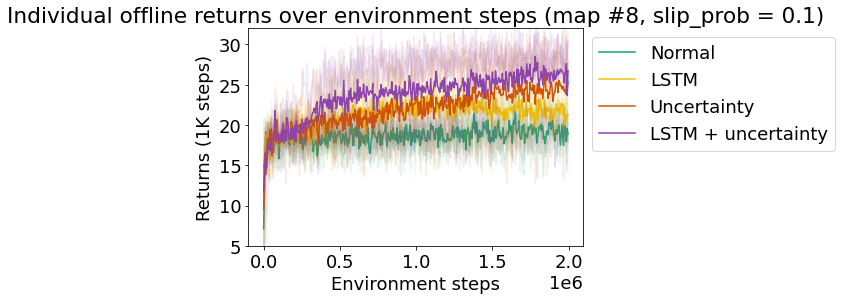

In [166]:
# with slip
fig, ax = plt.figure(), plt.axes()


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    ax.plot(x, means, label=key, color=color)

    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
#     plt.fill_between(x, means - std_err, means + std_err,
#                          color=color, alpha=0.2)

ax.set_ylim(5, 32)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Individual offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [154]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [155]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=100)


In [156]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf8m_cnn_lstm_trunc_10': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=10, total_steps=4000000),
  20.342480000000002,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/66bd4c84dc9ef012d4049b76deda455e_Mon May 16 15:20:51 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/eb63bbd2653a3de07c58186cd6e711fc_Mon May 16 15:28:03 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/99d23e05e3fe73fa1f76f4ad49460f5b_Mon May 16 15:25:38 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/a92db1cae1d9515cd760c17901034c1a_Mon May 16 15:28:03 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/ab2c72fd3b6f306ce93c049407eaf3eb_Mon May 16 15:25:34 2022.npy')]),
 'uf8m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_si

In [157]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


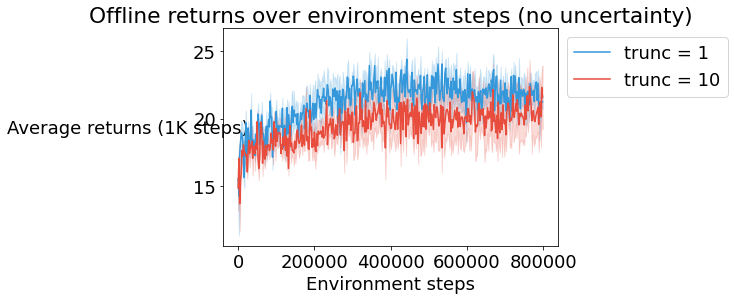

In [159]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
#     f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'}
}

fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/649464317.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


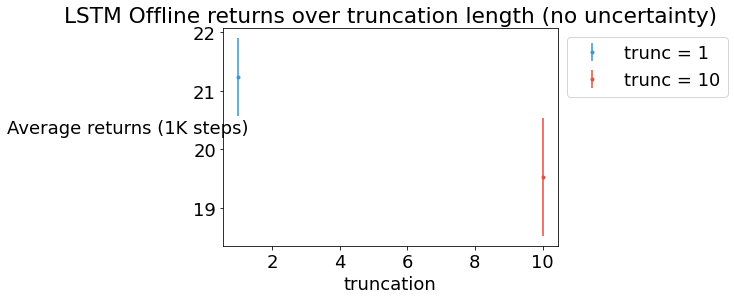

In [160]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [161]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf8m_cnn_lstm_trunc_10': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=0.85, slip_prob=0.1, trunc=10, total_steps=4000000),
  26.07832,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/cd3e01d8e25deea8e0f3c8fc88711e98_Mon May 16 16:11:34 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/1abaa966b644ac31725bf793e7bf70cc_Mon May 16 16:31:02 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/6aa3872a673713661a27c3422392626f_Mon May 16 16:31:02 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/06ad1672338317126bc6b792bd9f1fd4_Mon May 16 16:31:02 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/uf8_sweep_4m/uf8m_cnn_lstm/a83390f9b09db0198263c94601863510_Mon May 16 16:21:07 2022.npy')]),
 'uf8m_cnn_lstm_trunc_1': (args(buffer_size=100000, step_size=1e-05,

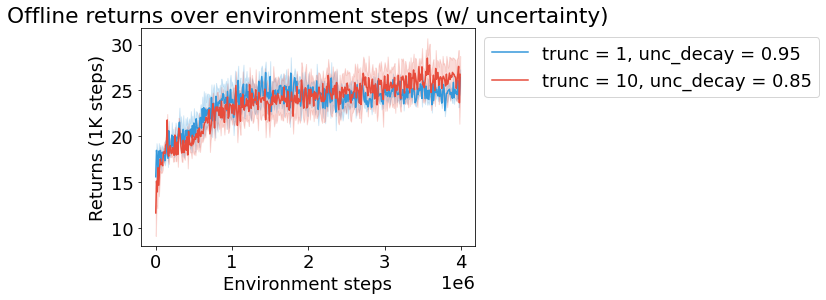

In [170]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
#     f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'}
}


fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [24.5716     25.1923     22.85496667]
k: 5, step_means: [24.10026667 18.5381     24.1317    ]
k: 10, step_means: [21.5127 18.3967 24.2826]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_30691/49689706.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


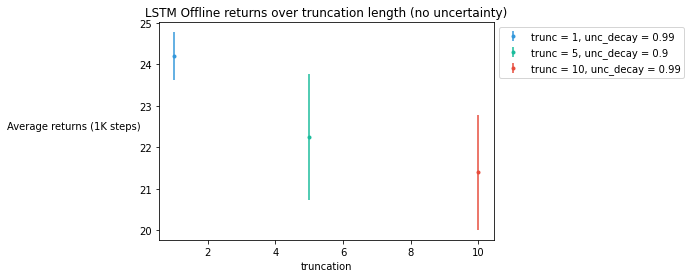

In [51]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')